# Model Interpreter via XAI

In this tutorial, we use `xai` to analyze a trained model and its features.
The tutorial contains 3 parts:
- feature distribution analysis
- trained model feature importance analysis
- model interpretation via explanation aggregation

### Prerequisites : Import libraries

`xai.model.interpreter` is the main package that users of XAI interact with. 

In [1]:
# Some auxiliary imports for the tutorial
import sys
import random
import numpy as np

from pprint import pprint
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Set seed for reproducibility
np.random.seed(123456)

# Set the path so that we can import ExplainerFactory
sys.path.append('../../')

/anaconda3/envs/xai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Main XAI imports
import xai
from xai.model.interpreter.model_interpreter import ModelInterpreter

In this tutorial, we train a sample `RandomForestClassifier` model on the Wisconsin breast cancer dataset, a sample binary classification problem that is provided by scikit-learn (details can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer)). We will use APIs in `xai.model_interpreter` package to conduct feature analysis, feature ranking and model interpretation.

In [3]:
# Load the dataset and prepare training and test sets
raw_data = datasets.load_breast_cancer()
X, y = raw_data['data'], raw_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 1. Feature Analysis

Key parameters used in feature analysis:
- feature_names: a list of str, names of each feature.
- feature_types: a list of str, pre-defined type for each feature.
- train_x: numpy.dnarray, training data. Each row is a training sample, each column is a feature.
- labels: a list of str/int, the class label for each training sample.
- trained_model: model object, the trained model object.

#### Feature Distribution

To analyze the feature distribution, we need to import `xai.model_interpreter.FeatureInterpreter` to initialize a `FeatureInterpreter` and call the `get_feature_distribution()` function.

In [4]:
# Define the feature data type and feature names
from xai.data.constants import DATATYPE
feature_names = raw_data['feature_names'].tolist()
feature_types = [DATATYPE.NUMBER]*len(feature_names)

from xai.model.interpreter.feature_interpreter import FeatureInterpreter
feature_interpreter = FeatureInterpreter(feature_names=feature_names)

stats = feature_interpreter.get_feature_distribution(feature_types=feature_types,train_x=X_train,labels=y_train)

We use our plot helper class `NotebookPlots` to plot the feature distribution results for the first 3 features. Details for each type of stats can be found in `xai.data.explorer` under different data type packages.

### mean radius

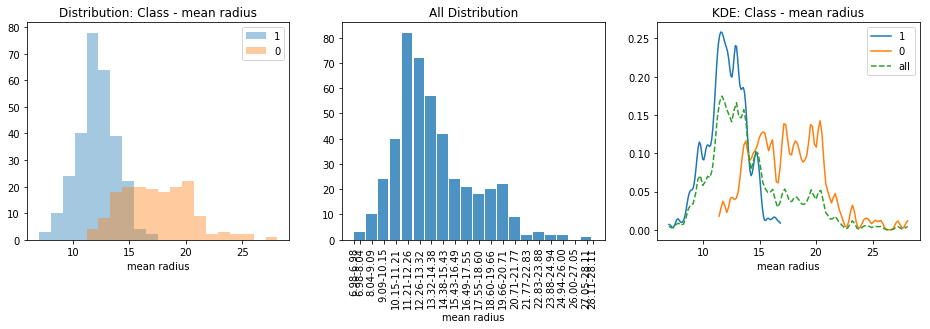

,class,max,mean,median,min,sd,total_count
0,1,16.84,12.095455,1.700759,6.981,16.84,286
1,0,28.11,17.468462,3.158721,11.420,28.11,169
2,all,28.11,14.091143,3.502028,6.981,28.11,455


### mean texture

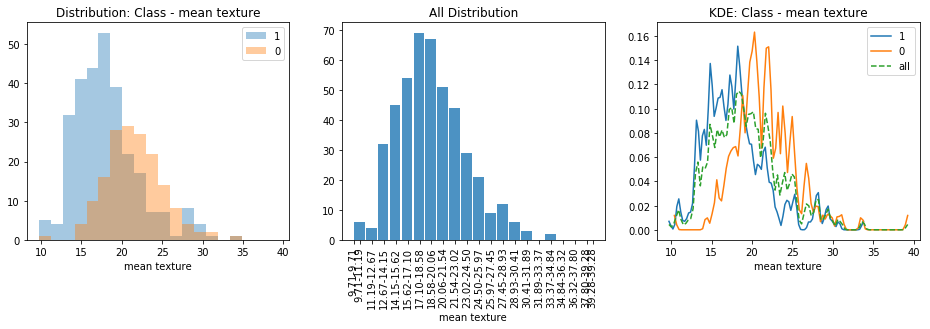

,class,max,mean,median,min,sd,total_count
0,1,33.81,18.066643,4.013245,9.71,33.81,286
1,0,39.28,21.600118,3.738992,10.38,39.28,169
2,all,39.28,19.379077,4.269827,9.71,39.28,455


### mean perimeter

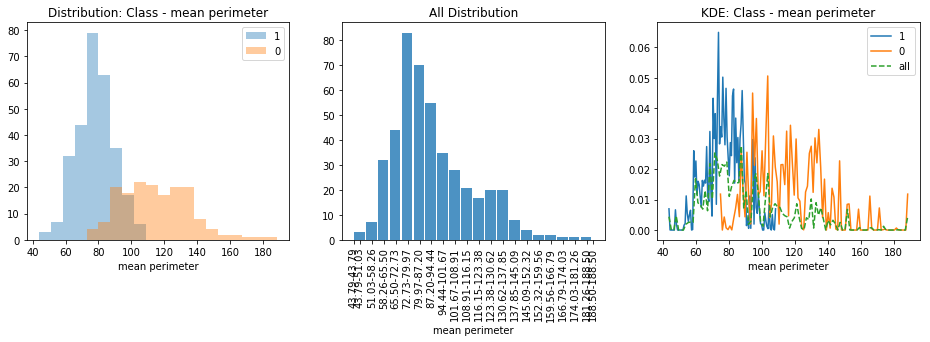

,class,max,mean,median,min,sd,total_count
0,1,108.4,77.730105,11.292902,43.79,108.4,286
1,0,188.5,115.335503,21.653977,75.00,188.5,169
2,all,188.5,91.697824,24.176163,43.79,188.5,455


In [5]:
from xai.plots.data_stats_notebook_plots import NotebookPlots
plotter = NotebookPlots()

sample_features = feature_names[:3]
for feature_name in sample_features:
    (label_feature_stats, all_feature_stats) = stats[feature_name]
    
    plotter.plot_labelled_numerical_stats(labelled_stats=label_feature_stats, # stats for each class
                                          all_stats=all_feature_stats, # stats for all classes
                                          label_column='Class', # column name for label
                                          feature_column=feature_name) # column name for feature

#### Feature correlation
To analyze the feature correlction, we need to import `xai.model_interpreter.FeatureInterpreter` to initialize a `FeatureInterpreter` and call the `get_feature_correlation()` function. Same `FeatureInterpreter` object can be reused here for correlation analysis. 

In this sample, as all the features are numerical features, correlation are calculated using Pearson's testing as a default setup. And we use plot helper function to plot the heatmap for the correlation between all features.

../../xai/model/interpreter/feature_interpreter.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  correlation_types[col1][col2] = method
/anaconda3/envs/xai/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


#### Correlation Type: pearson

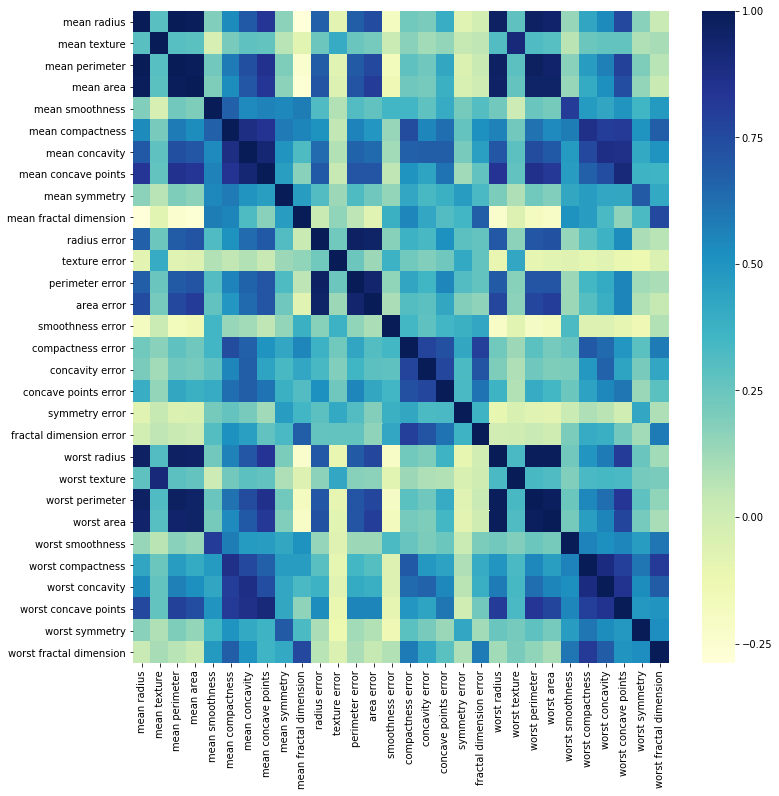

In [6]:
types, values = feature_interpreter.get_feature_correlation(feature_types=feature_types,train_x=X_train)
plotter.plot_correlation_heatmap(types,values)

### 2. Feature Importance

As feature importance is associated with a model, we need to firstly train a sample model first. In this tutorial, we train a sample `RandomForestClassifier` model on the the dataset.

In [7]:
# Instantiate a classifier, train, and evaluate on test set
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.956140350877193

To analysze the feature importance ranking, we need to import `xai.model_interpreter.FeatureInterpreter` to initialize a `FeatureInterpreter` and call the `get_feature_ranking()` function. Same `FeatureInterpreter` object can be reused here for feature importance ranking.

The code below shows the feature importance used the default method provided by the model itself.

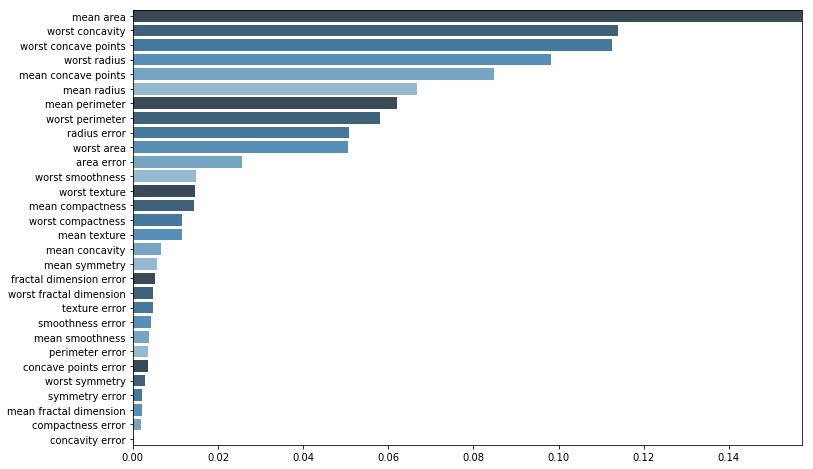

In [8]:
feature_importance_ranking = feature_interpreter.get_feature_importance_ranking(trained_model=clf, 
                                                                                train_x=X_train,
                                                                                method='default')
plotter.plot_feature_importance_ranking(feature_importance_ranking)

By changing the method, we can get feature importance based on different criterion. 
The code below shows the feature importance calculated by shap value.

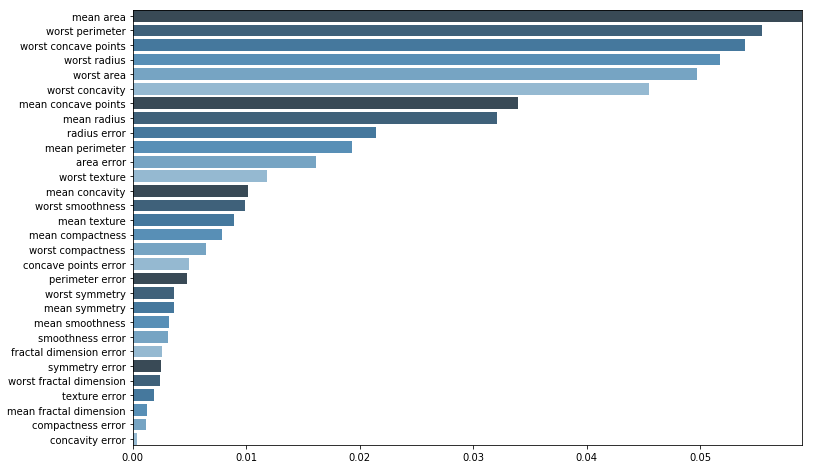

In [9]:
feature_importance_ranking = feature_interpreter.get_feature_importance_ranking(trained_model=clf, 
                                                                                train_x=X_train,
                                                                                method='shap')
plotter.plot_feature_importance_ranking(feature_importance_ranking)

### 3. Model Interpretation by aggregate explanations

One way to interpret the model is by aggregating the individual explanations which tries to explain the model locally

#### Step 0. Import the `ModelInterpreter`

In [10]:
from xai.model.interpreter.model_interpreter import ModelInterpreter

#### Step 1. Define domain and algorithm

As model interpreter is using a model-agnostic explainer, domain and algorithm is dependent on `xai.explainer` package. See details in `xai.explainer.config`

In [11]:
from xai.explainer.config import DOMAIN, ALG
model_interpreter = ModelInterpreter(domain=DOMAIN.TABULAR, algorithm=ALG.LIME)

#### Step 2. Build interpreter

Based on the domain and algorithm chosen, build the explainer in the interpreter by passing in the required parameter. 

Required parameters include:
- training data
- training labels
- model prediction functions

See details in `xai.explainer`.

In [12]:
model_interpreter.build_interpreter(
    training_data=X_train,
    training_labels=y_train,
    mode=xai.MODE.CLASSIFICATION,
    predict_fn=clf.predict_proba,
    column_names=raw_data['feature_names'],
    class_names=list(raw_data['target_names'])
)

#### Step 3. Interpreter the model with training data 

#### Model Interpretation
The interpreter explains the model by aggregate explainations based on predicted classes. By calling `interpret_model()` with training data, the explainer will explain each sample on a local manner and aggregate the local explanations on each class to provide a global interpretation statistically. For now, we support 3 types of statistical aggregation:
- top_k: how often a feature appears in the top K features in the explanation
- average_score: average score for each feature in the explanation
- average_ranking: average ranking for each feature in the explanation

Default type is `top_k`.

In [13]:
stats = model_interpreter.interpret_model(samples=X_train, stats_type='top_k',k=5)

Interpret 100/455 samples
Interpret 200/455 samples
Interpret 300/455 samples
Interpret 400/455 samples


Interpretation for Class 1


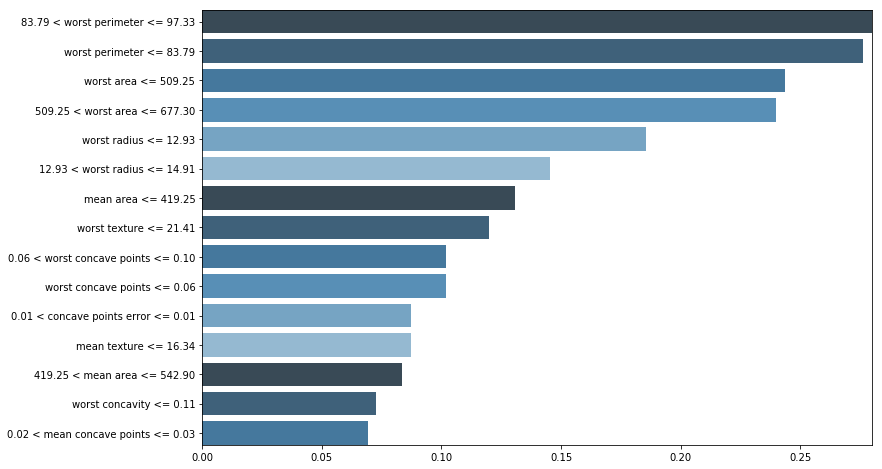

Interpretation for Class 0


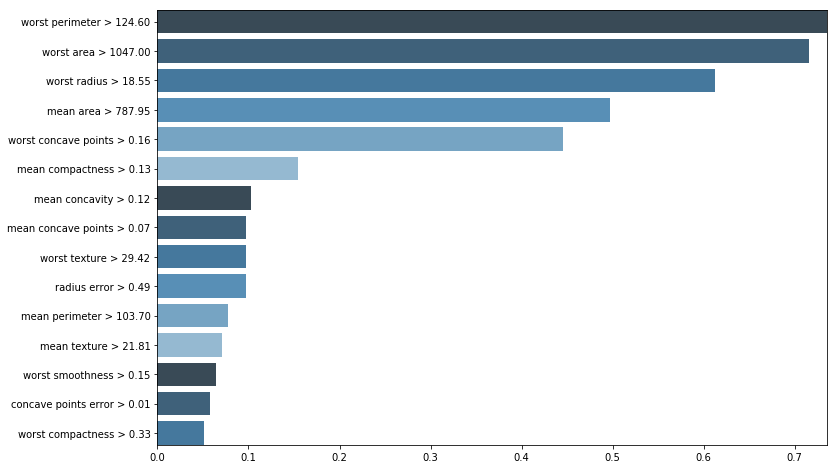

In [14]:
class_stats, total_count = stats
num_of_top_explanation = 15
for _class,_explanation_ranking in class_stats.items():
    print('Interpretation for Class %s'%_class)
    plotter.plot_feature_importance_ranking([(key,value) for key,value in _explanation_ranking.items()]
                                            [:num_of_top_explanation])

#### Error Analaysis
Error analysis helps to aggregate explanations on samples that are wrongly classified in the validation data set. 

By calling function `error_analysis()`, it returns a stats of top explanations for wrongly classified samples.

In [15]:
stats = model_interpreter.error_analysis(class_num=2, valid_x=X_test, valid_y=y_test, stats_type='average_score', k=5)

Analyze 10/114 samples
Analyze 20/114 samples
Analyze 30/114 samples
Analyze 40/114 samples
Analyze 50/114 samples
Analyze 60/114 samples
Analyze 70/114 samples
Analyze 80/114 samples
Analyze 90/114 samples
Analyze 100/114 samples
Analyze 110/114 samples


3 sample from class [1] is wrongly classified as class[0]
 - Top reasons that they are predicted as class[0]


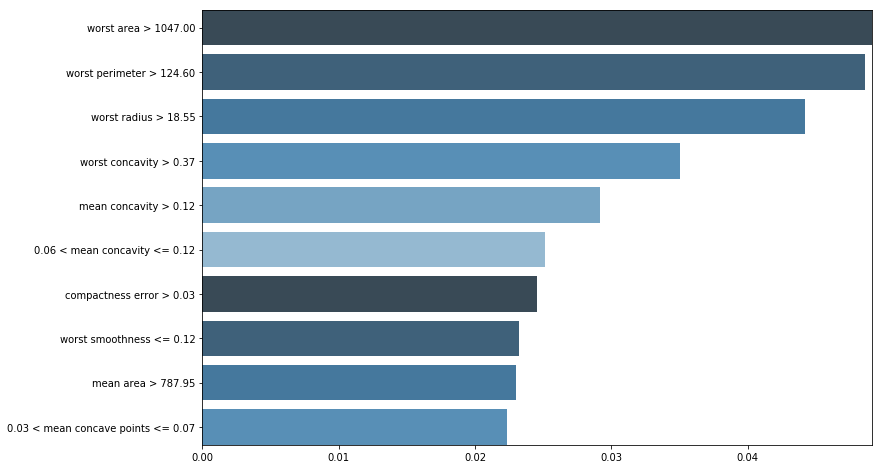

2 sample from class [0] is wrongly classified as class[1]
 - Top reasons that they are predicted as class[1]


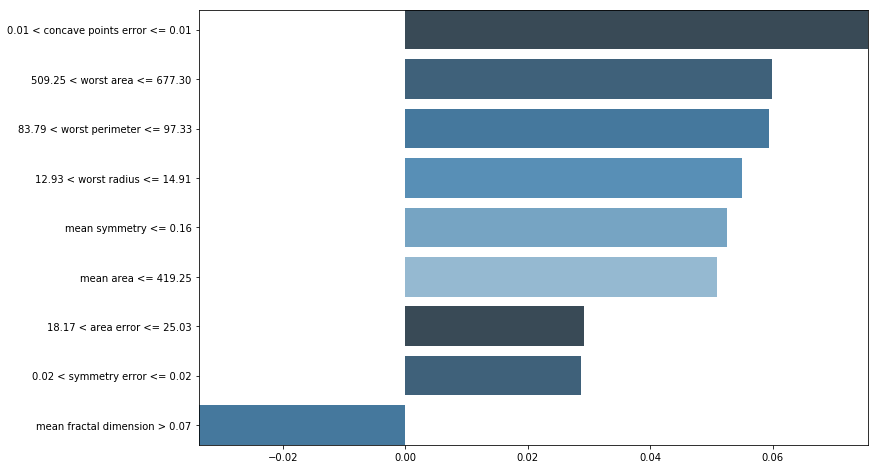

In [16]:
num_of_top_explanation = 10
for (gt_class,predict_class),(_explanation_dict,num_sample) in stats.items():
    print('%s sample from class [%s] is wrongly classified as class[%s]'%(num_sample,gt_class,predict_class))
    print(' - Top reasons that they are predicted as class[%s]'%predict_class)
    plotter.plot_feature_importance_ranking([(key,value) for key,value in _explanation_dict[predict_class].items()]
                                            [:num_of_top_explanation])